<a href="https://colab.research.google.com/github/2303A52084/Explainable-ai-b39/blob/main/research_paper1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (300, 13)
  PK  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75      0.0                     582.0       0.0               20.0   
1    55      0.0                    7861.0       0.0               38.0   
2    65      0.0                     146.0       0.0               20.0   
3    50      1.0                     111.0       0.0               20.0   
4    65      1.0                     160.0       1.0               20.0   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                  1.0  265000.00               1.9         130.0  1.0   
1                  0.0  263358.03               1.1         136.0  1.0   
2                  0.0  162000.00               1.3         129.0  1.0   
3                  0.0  210000.00               1.9         137.0  1.0   
4                  0.0  327000.00               2.7         116.0  0.0   

   smoking  time  DEATH_EVENT  
0      0.0   4.0          1.0  
1      0.0   6.0       

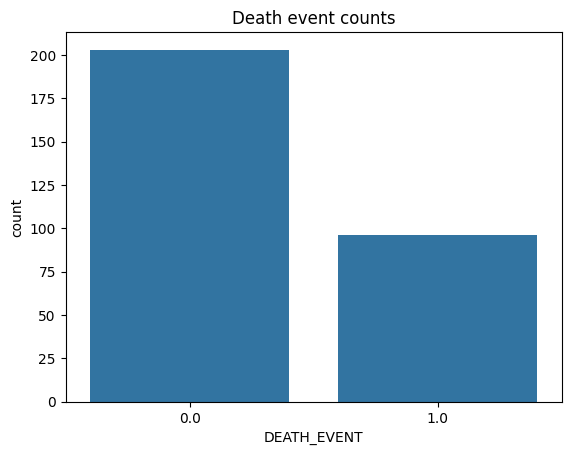

Numeric cols: ['anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
Cat cols: ['PK\x03\x04\x14']
Logistic Regression AUC: 0.8562259306803595
Logistic Regression report:
               precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        41
         1.0       0.73      0.58      0.65        19

    accuracy                           0.80        60
   macro avg       0.78      0.74      0.75        60
weighted avg       0.79      0.80      0.79        60

Random Forest AUC: 0.883183568677792
Random Forest report:
               precision    recall  f1-score   support

         0.0       0.85      0.95      0.90        41
         1.0       0.86      0.63      0.73        19

    accuracy                           0.85        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.85      0.85      0.84        60


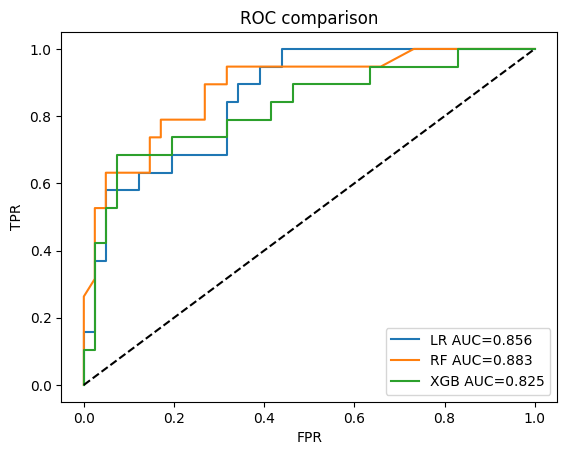

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 3 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 4 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 20 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


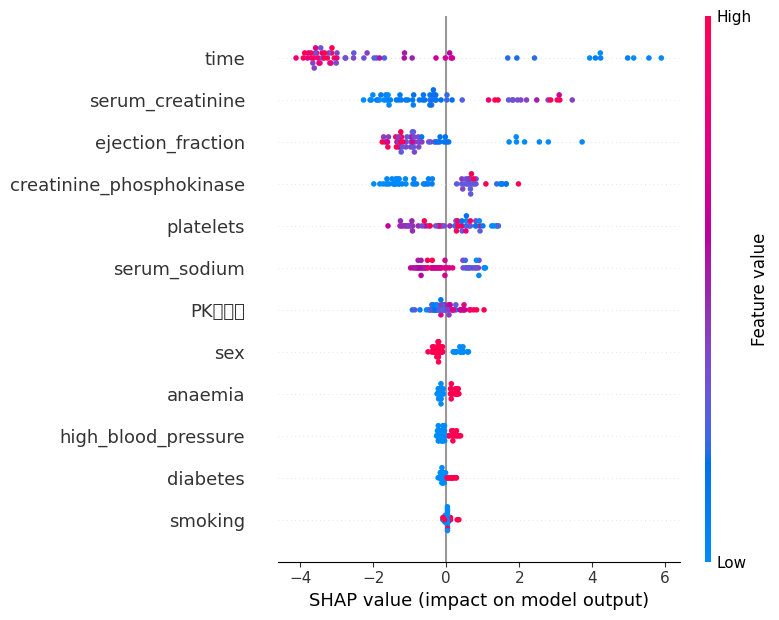

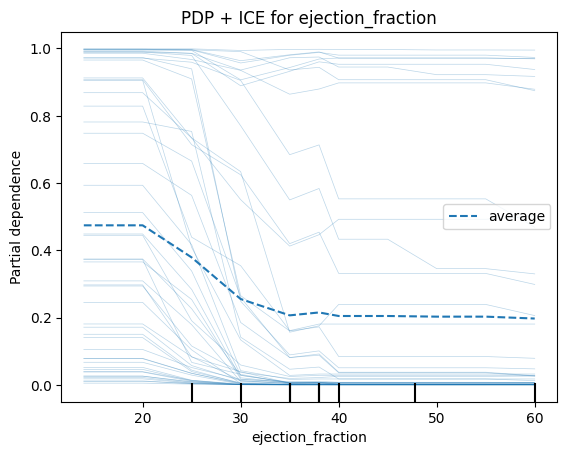

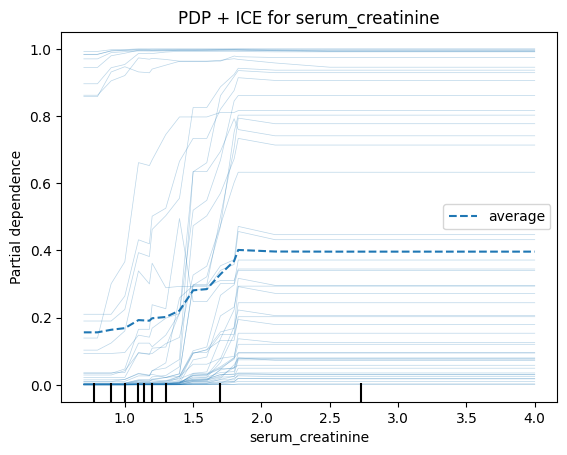

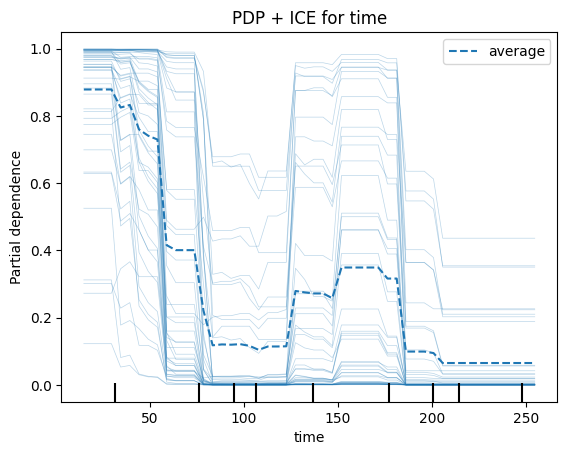

ModuleNotFoundError: No module named 'lime'

In [1]:
# heart_failure_prediction.py
# Requirements: pandas, numpy, scikit-learn, matplotlib, seaborn, xgboost, shap, lime
# pip install pandas numpy scikit-learn matplotlib seaborn xgboost shap lime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

# 1) Load data
try:
    df = pd.read_csv("heart.csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("heart.csv", encoding='latin1')

print("Shape:", df.shape)
print(df.head())

# 2) Basic EDA
print(df.info())
print(df.describe())
print("Target distribution:\n", df['DEATH_EVENT'].value_counts())

sns.countplot(x='DEATH_EVENT', data=df)
plt.title('Death event counts')
plt.show()

# 3) Preprocessing
target = 'DEATH_EVENT'
df.dropna(subset=[target], inplace=True)

X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Cat cols:", cat_cols)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 5) Logistic Regression
clf_lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
clf_lr.fit(X_train, y_train)
y_pred_proba_lr = clf_lr.predict_proba(X_test)[:,1]
print("Logistic Regression AUC:", roc_auc_score(y_test, y_pred_proba_lr))
print("Logistic Regression report:\n", classification_report(y_test, clf_lr.predict(X_test)))

# 6) Random Forest
clf_rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])
clf_rf.fit(X_train, y_train)
y_pred_proba_rf = clf_rf.predict_proba(X_test)[:,1]
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba_rf))
print("Random Forest report:\n", classification_report(y_test, clf_rf.predict(X_test)))

# 7) XGBoost
clf_xgb = Pipeline([
    ('prep', preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=200, eval_metric='logloss', random_state=42))
])
clf_xgb.fit(X_train, y_train)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:,1]
print("XGBoost AUC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("XGBoost report:\n", classification_report(y_test, clf_xgb.predict(X_test)))

# 8) ROC curve
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC={roc_auc_score(y_test,y_pred_proba_lr):.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={roc_auc_score(y_test,y_pred_proba_rf):.3f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB AUC={roc_auc_score(y_test,y_pred_proba_xgb):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC comparison')
plt.show()

# 9) SHAP
X_test_pre = preprocessor.transform(X_test)
explainer = shap.Explainer(clf_xgb.named_steps['clf'])
shap_values = explainer(X_test_pre)

feature_names = num_cols + cat_cols
shap.summary_plot(shap_values, features=X_test_pre, feature_names=feature_names, show=True)

# 10) PDP + ICE
from sklearn.inspection import PartialDependenceDisplay
features_to_plot = ['ejection_fraction', 'serum_creatinine', 'time']
for feature in features_to_plot:
    PartialDependenceDisplay.from_estimator(
        clf_xgb,
        X_test,
        [feature],
        kind="both",   # PDP + ICE
        subsample=50,
        grid_resolution=50
    )
    plt.title(f"PDP + ICE for {feature}")
    plt.show()

# 11) LIME
from lime.lime_tabular import LimeTabularExplainer

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

lime_explainer = LimeTabularExplainer(
    training_data=X_train_pre,
    feature_names=feature_names,
    class_names=['Alive','Death'],
    discretize_continuous=True,
    mode='classification'
)

i = 0  # first test instance
exp = lime_explainer.explain_instance(
    data_row=X_test_pre[i],
    predict_fn=clf_xgb.named_steps['clf'].predict_proba
)

print("LIME explanation for first test instance:")
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.show()

# 12) Save model
import joblib
joblib.dump(clf_xgb, "xgb_heart_model.pkl")
print("Model saved to xgb_heart_model.pkl")


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8806c194c7038510ead400a95dedc2c5ea157b38f028f55e2a292c7e6bc65e4b
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


Shape: (300, 13)
  PK  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75      0.0                     582.0       0.0               20.0   
1    55      0.0                    7861.0       0.0               38.0   
2    65      0.0                     146.0       0.0               20.0   
3    50      1.0                     111.0       0.0               20.0   
4    65      1.0                     160.0       1.0               20.0   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                  1.0  265000.00               1.9         130.0  1.0   
1                  0.0  263358.03               1.1         136.0  1.0   
2                  0.0  162000.00               1.3         129.0  1.0   
3                  0.0  210000.00               1.9         137.0  1.0   
4                  0.0  327000.00               2.7         116.0  0.0   

   smoking  time  DEATH_EVENT  
0      0.0   4.0          1.0  
1      0.0   6.0       

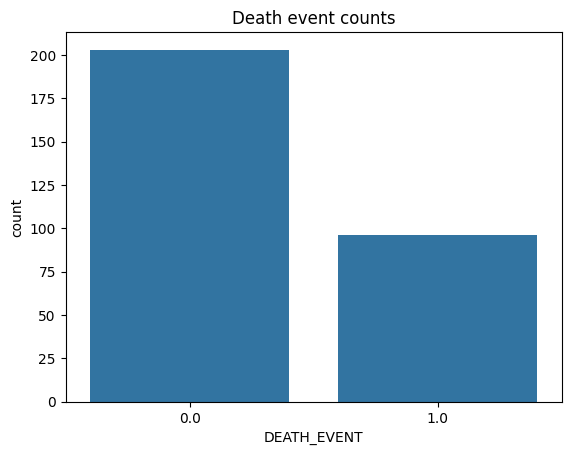

Numeric cols: ['anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
Cat cols: []
Logistic Regression AUC: 0.8318356867779204
Logistic Regression report:
               precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        41
         1.0       0.73      0.58      0.65        19

    accuracy                           0.80        60
   macro avg       0.78      0.74      0.75        60
weighted avg       0.79      0.80      0.79        60

Random Forest AUC: 0.8812580231065469
Random Forest report:
               precision    recall  f1-score   support

         0.0       0.85      0.95      0.90        41
         1.0       0.86      0.63      0.73        19

    accuracy                           0.85        60
   macro avg       0.85      0.79      0.81        60
weighted avg       0.85      0.85      0.84        60

XGBoost AUC: 0

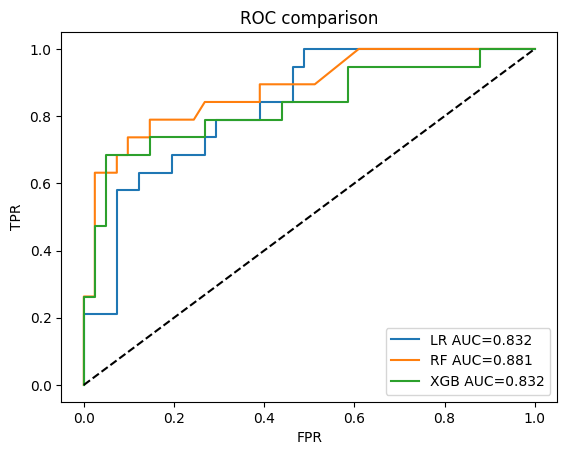

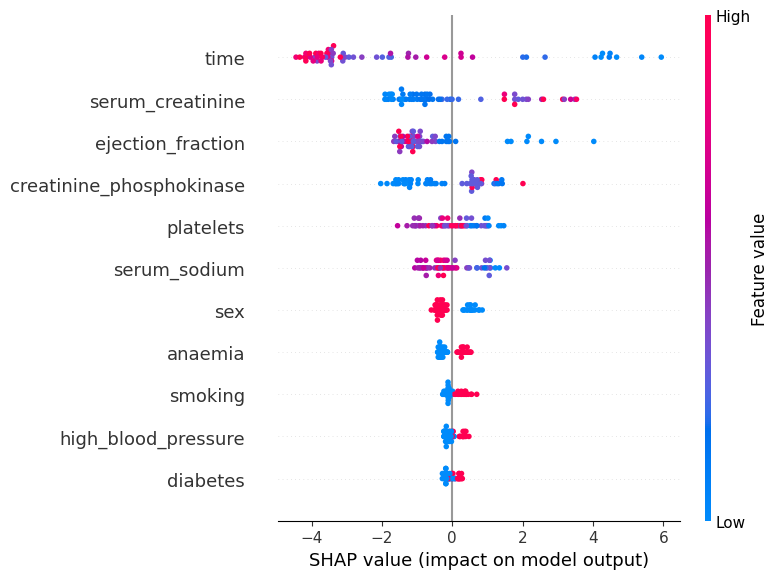

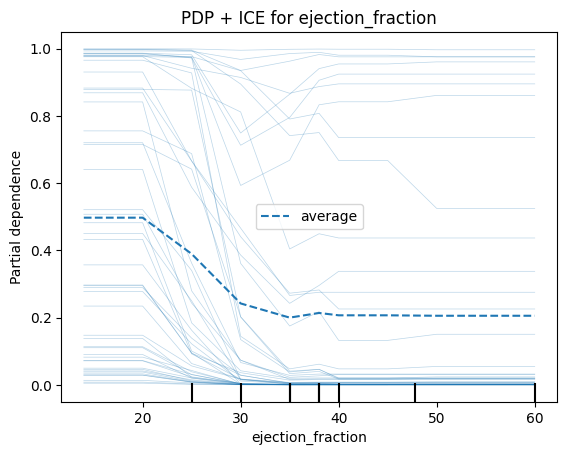

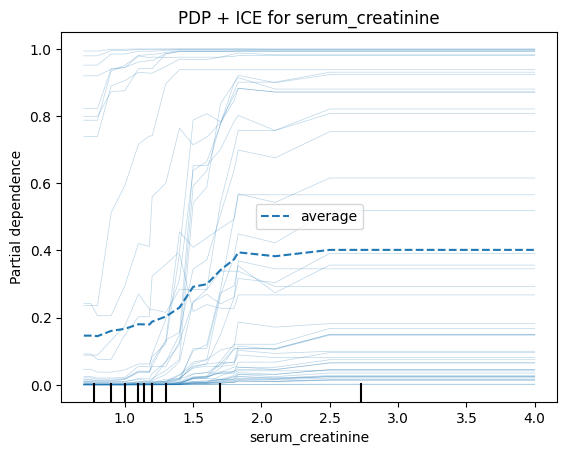

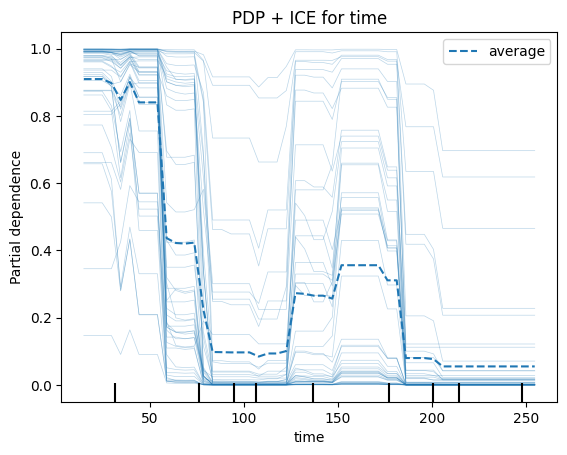

LIME explanation for first test instance:


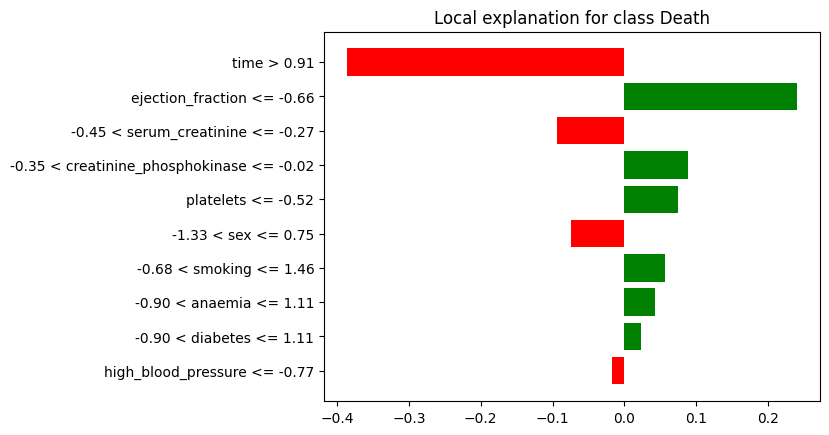

Model saved to xgb_heart_model.pkl


In [3]:
# heart_failure_prediction.py
# Requirements: pandas, numpy, scikit-learn, matplotlib, seaborn, xgboost, shap, lime
# pip install pandas numpy scikit-learn matplotlib seaborn xgboost shap lime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

# 1) Load data
try:
    df = pd.read_csv("heart.csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("heart.csv", encoding='latin1')

print("Shape:", df.shape)
print(df.head())

# 2) Basic EDA
print(df.info())
print(df.describe())
print("Target distribution:\n", df['DEATH_EVENT'].value_counts())

sns.countplot(x='DEATH_EVENT', data=df)
plt.title('Death event counts')
plt.show()

# 3) Preprocessing
target = 'DEATH_EVENT'
df.dropna(subset=[target], inplace=True)

# Remove the problematic column
if 'PK\x03\x04\x14' in df.columns:
    df.drop(columns=['PK\x03\x04\x14'], inplace=True)

X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Cat cols:", cat_cols)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 5) Logistic Regression
clf_lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
clf_lr.fit(X_train, y_train)
y_pred_proba_lr = clf_lr.predict_proba(X_test)[:,1]
print("Logistic Regression AUC:", roc_auc_score(y_test, y_pred_proba_lr))
print("Logistic Regression report:\n", classification_report(y_test, clf_lr.predict(X_test)))

# 6) Random Forest
clf_rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])
clf_rf.fit(X_train, y_train)
y_pred_proba_rf = clf_rf.predict_proba(X_test)[:,1]
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_proba_rf))
print("Random Forest report:\n", classification_report(y_test, clf_rf.predict(X_test)))

# 7) XGBoost
clf_xgb = Pipeline([
    ('prep', preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=200, eval_metric='logloss', random_state=42))
])
clf_xgb.fit(X_train, y_train)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:,1]
print("XGBoost AUC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("XGBoost report:\n", classification_report(y_test, clf_xgb.predict(X_test)))

# 8) ROC curve
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC={roc_auc_score(y_test,y_pred_proba_lr):.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={roc_auc_score(y_test,y_pred_proba_rf):.3f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB AUC={roc_auc_score(y_test,y_pred_proba_xgb):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC comparison')
plt.show()

# 9) SHAP
X_test_pre = preprocessor.transform(X_test)
explainer = shap.Explainer(clf_xgb.named_steps['clf'])
shap_values = explainer(X_test_pre)

feature_names = num_cols + cat_cols
shap.summary_plot(shap_values, features=X_test_pre, feature_names=feature_names, show=True)

# 10) PDP + ICE
from sklearn.inspection import PartialDependenceDisplay
features_to_plot = ['ejection_fraction', 'serum_creatinine', 'time']
for feature in features_to_plot:
    if feature in X_test.columns:
        PartialDependenceDisplay.from_estimator(
            clf_xgb,
            X_test,
            [feature],
            kind="both",   # PDP + ICE
            subsample=50,
            grid_resolution=50
        )
        plt.title(f"PDP + ICE for {feature}")
        plt.show()
    else:
        print(f"Feature '{feature}' not found in X_test.")


# 11) LIME
from lime.lime_tabular import LimeTabularExplainer

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

lime_explainer = LimeTabularExplainer(
    training_data=X_train_pre,
    feature_names=feature_names,
    class_names=['Alive','Death'],
    discretize_continuous=True,
    mode='classification'
)

i = 0  # first test instance
exp = lime_explainer.explain_instance(
    data_row=X_test_pre[i],
    predict_fn=clf_xgb.named_steps['clf'].predict_proba
)

print("LIME explanation for first test instance:")
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.show()

# 12) Save model
import joblib
joblib.dump(clf_xgb, "xgb_heart_model.pkl")
print("Model saved to xgb_heart_model.pkl")